### Script for Figure 1 b and c 
Cross-sectional plot of model setup


In [1]:
%matplotlib inline

In [2]:
from matplotlib import rc
rc('font', **{'size':30})
#rc('text', usetex=True)
rc('xtick', labelsize=30) 
rc('ytick', labelsize=30) 
rc('axes', titlesize=30)    # fontsize of the axes title
rc('axes', labelsize=30) 
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import xarray as xr
from xgcm import Grid

In [3]:
nlayers = 4
H = 3000 #maximum depth

In [4]:
from dask.distributed import Client

c=Client(local_directory = '/scratch/v45/qo9901/') 
c

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41733 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41733/status,
Dashboard: /proxy/41733/status,Workers: 4
Total threads: 4,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33361,Workers: 4
Dashboard: /proxy/41733/status,Total threads: 4
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:36899,Total threads: 1
Dashboard: /proxy/38769/status,Memory: 25.00 GiB
Nanny: tcp://127.0.0.1:35083,


## Inputting data

In [5]:
WindList =  '/g/data/v45/qo9901/idealised-ASC/plotting-datasets/windstress_input.nc'
dsx_wind = xr.open_mfdataset(WindList, engine='netcdf4', parallel=True)
dsx_wind

<xarray.Dataset>
Dimensions:   (x: 1000, y: 500)
Coordinates:
  * x         (x) float64 0.0 1.0 2.0 3.0 4.0 ... 995.0 996.0 997.0 998.0 999.0
  * y         (y) float64 -250.0 -249.0 -248.0 -247.0 ... 247.0 248.0 249.0
Data variables:
    STRESS_X  (y, x) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    STRESS_Y  (y, x) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>

In [6]:
stressx = dsx_wind.STRESS_X

In [7]:
dsx_prog_mean = xr.open_mfdataset('/g/data/v45/qo9901/idealised-ASC/plotting-datasets/dsx_prog_setup_tmean_example_10years.nc/', combine = 'by_coords', decode_times=False, chunks={"Time": 10},engine='netcdf4', parallel=True)

### Velocity plots with depth

In [8]:
## the depth space plot for u and h
def transform_rho_to_z_space_4layer(diag, h , H, depth_interval):
    '''
    Function to transform layered model diagnostics into depth coordinates at a single time step
    
    NOTE transform all diag to h space first
    
    INPUTS
    diag : diagnostics in array of dimensions (layer, y)
    h : layer thickness diagnostics in array of dimension (layer, y)
    H : depth of hbasin e.g. 1600m
    depth_interval: integer interval of depth coordinate e.g. 10m 
    
    OUTPUT
    diag_z : diagnostics in DataArray of dimensions (z, y)
    
    '''
    z_coord = np.arange(0,H,depth_interval)
    diag_z = np.zeros((len(z_coord),len(diag[0,:])))
    rho_z = np.zeros((len(z_coord),len(diag[0,:])))
    
    Y = len(diag[0,:])

    for y in range(Y):
        for z in range(len(z_coord)):
            if z_coord[z] <= h[0,y]: 
                diag_z[z,y] = diag[0,y]
                rho_z[z,y] = 1027.6
            elif (z_coord[z] <= h[1,y]) and  (z_coord[z] > h[0,y]):
                diag_z[z,y] = diag[1,y]
                rho_z[z,y] = 1028.0
            elif (z_coord[z] <= h[2,y]) and  (z_coord[z] > h[1,y]):
                diag_z[z,y] = diag[2,y]
                rho_z[z,y] = 1028.1
            elif (z_coord[z] <= h[3,y]) and  (z_coord[z] > h[2,y]):
                diag_z[z,y] = diag[3,y]
                rho_z[z,y] = 1028.3
            elif (z_coord[z] > h[3,y]):
                diag_z[z,y] = 0
                rho_z[z,y] = 0
                
                
                    
    return diag_z, rho_z, z_coord

### Regridding for interpolation

In [9]:
import xgcm
grid = xr.open_mfdataset('/g/data/v45/qo9901/idealised-ASC/plotting-datasets/ocean_geometry.nc', combine='by_coords')
grid_new = grid.rename({'latq': 'yq','lonq': 'xq','lath': 'yh','lonh': 'xh'})
grid_new

<xarray.Dataset>
Dimensions:  (yh: 500, xh: 1000, yq: 500, xq: 1000)
Coordinates:
  * yh       (yh) float64 -249.5 -248.5 -247.5 -246.5 ... 247.5 248.5 249.5
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * yq       (yq) float64 -249.0 -248.0 -247.0 -246.0 ... 248.0 249.0 250.0
  * xq       (xq) float64 -499.0 -498.0 -497.0 -496.0 ... 498.0 499.0 500.0
Data variables: (12/19)
    geolatb  (yq, xq) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    geolonb  (yq, xq) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    geolat   (yh, xh) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    geolon   (yh, xh) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    D        (yh, xh) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    f        (yq, xq) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    ...       ...
    dyBu     (yq, xq) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    Ah       (yh, xh) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    Aq       (yq, xq) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    dxCvo    (yq, xh) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    dyCuo    (yh, xq) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    wet      (yh, xh) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
Attributes:
    filename:  ./ocean_geometry.nc

In [10]:
ds = xr.merge([dsx_prog_mean.u, dsx_prog_mean.v, grid_new])
ds

<xarray.Dataset>
Dimensions:  (xq: 1000, yh: 500, zl: 4, xh: 1000, yq: 500)
Coordinates:
  * xq       (xq) float64 -499.0 -498.0 -497.0 -496.0 ... 498.0 499.0 500.0
  * yh       (yh) float64 -249.5 -248.5 -247.5 -246.5 ... 247.5 248.5 249.5
  * zl       (zl) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * yq       (yq) float64 -249.0 -248.0 -247.0 -246.0 ... 248.0 249.0 250.0
Data variables: (12/21)
    u        (zl, yh, xq) float32 dask.array<chunksize=(4, 500, 1000), meta=np.ndarray>
    v        (zl, yq, xh) float32 dask.array<chunksize=(4, 500, 1000), meta=np.ndarray>
    geolatb  (yq, xq) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    geolonb  (yq, xq) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    geolat   (yh, xh) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    geolon   (yh, xh) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    ...       ...
    dyBu     (yq, xq) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    Ah       (yh, xh) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    Aq       (yq, xq) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    dxCvo    (yq, xh) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    dyCuo    (yh, xq) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>
    wet      (yh, xh) float64 dask.array<chunksize=(500, 1000), meta=np.ndarray>

In [11]:
ds.coords['xq'].attrs.update(axis='X')
ds.coords['xh'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yq'].attrs.update(axis='Y')
ds.coords['yh'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   zl
Y Axis (not periodic, boundary=None):
  * center   yq --> right
  * right    yh --> center
X Axis (periodic, boundary=None):
  * center   xq --> right
  * right    xh --> center

interp
transform
wind
contour
interface


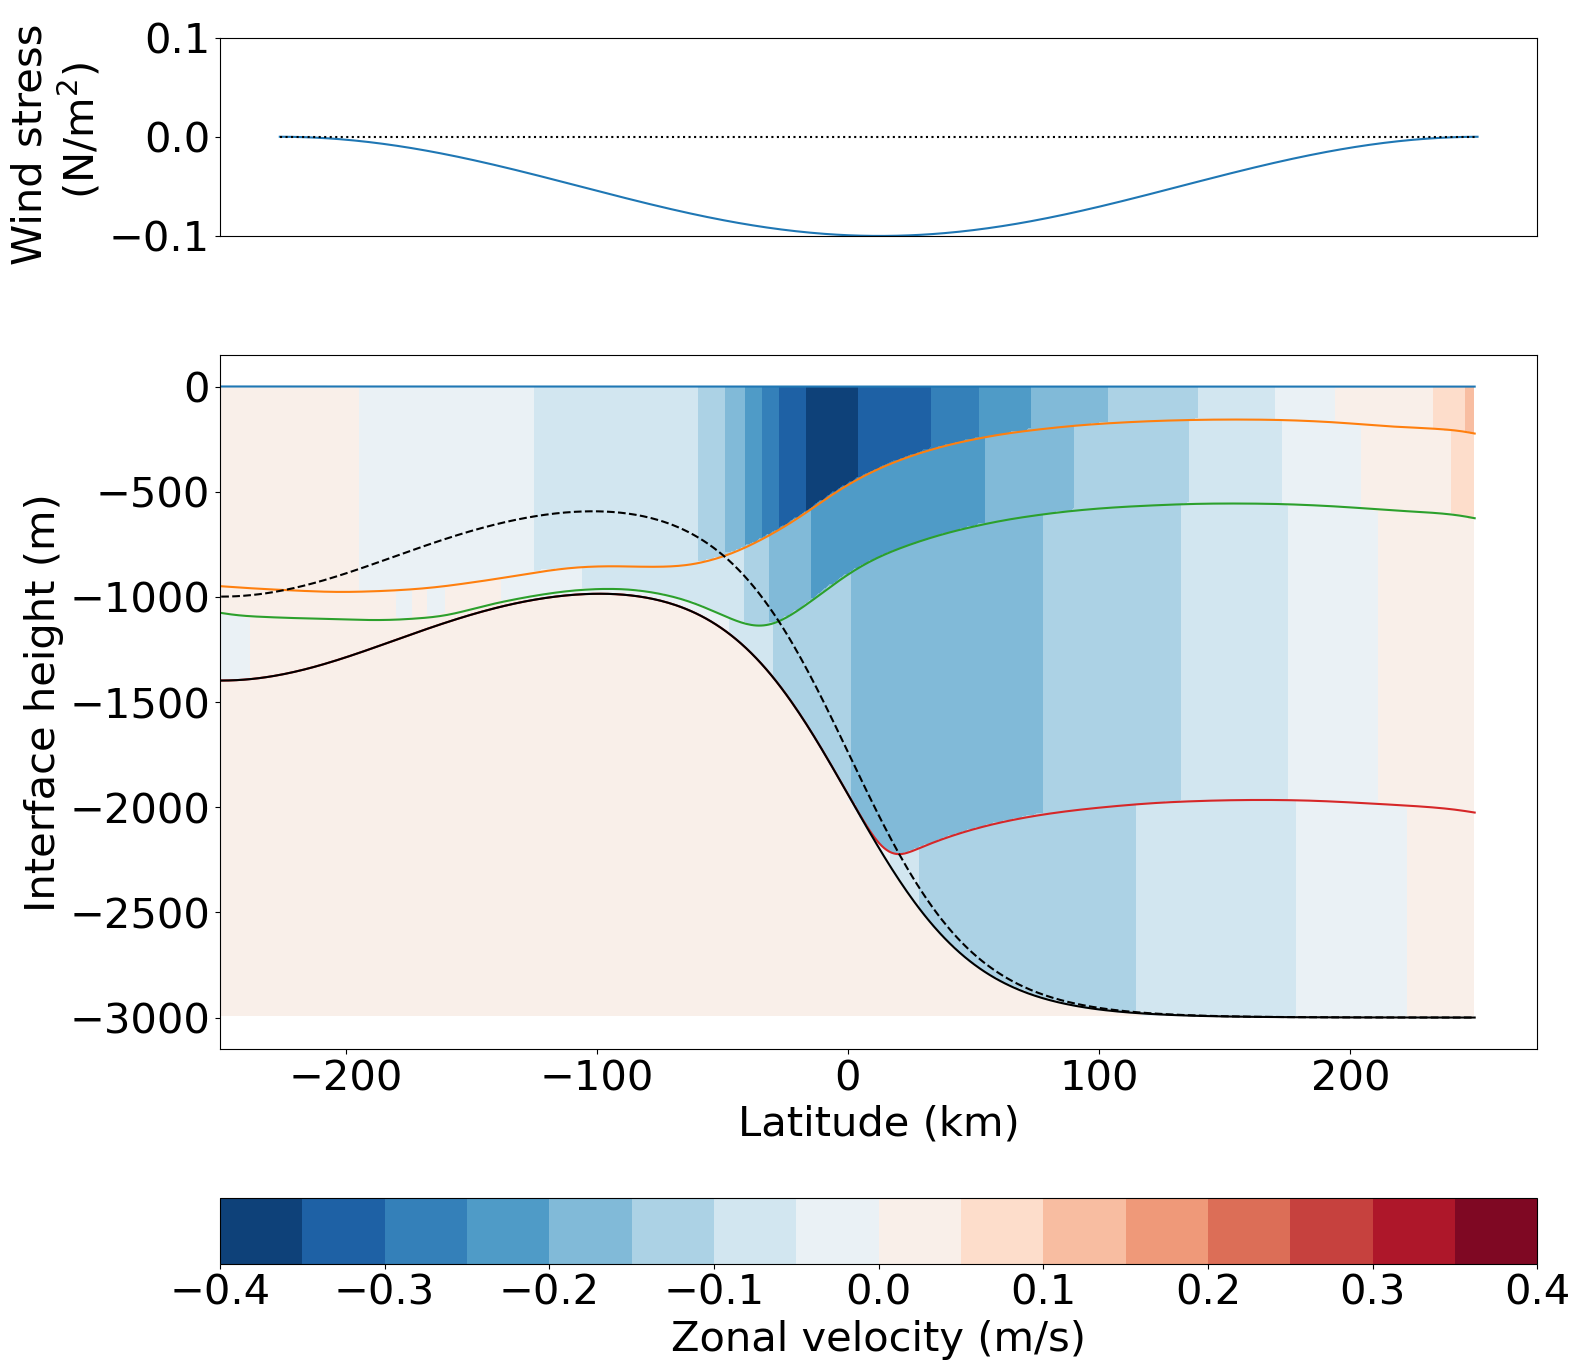

CPU times: user 7.3 s, sys: 849 ms, total: 8.15 s
Wall time: 7.85 s


In [20]:
%%time 
## this takes a while to interpolate
## WITH DATASET
## MEAN LAST 10 YEARS with extra canyon -- take time average velocities at cross-section of canyon
# u depth with wind stress subplot

fig, axs = plt.subplots(nrows = 2,gridspec_kw={'height_ratios': [3, 15]},figsize=(17,17))
u_diag_interp_t = grid.interp(dsx_prog_mean.u, axis = 'X').isel(xh = 500)
print('interp')
if nlayers == 4 : 
    u_z_100, rho_z_100, z_coord = transform_rho_to_z_space_4layer(u_diag_interp_t.values, dsx_prog_mean.h.isel(xh = 500).cumsum(dim = 'zl').values, H, 10)
print('transform')
    
#plot wind
eta = dsx_prog_mean.e.isel(xh = 500).load()
stressx.mean(dim = 'x').plot(ax = axs[0])#, xincrease = False)
axs[0].plot(stressx.coords['y'], np.zeros((len(stressx.coords['y']))),color = 'k', linestyle = 'dotted')
axs[0].set_ylabel('Wind stress \n (N/m$^{2}$)')
axs[0].set_xlabel('')
axs[0].set_xticks([])
axs[0].set_ylim([-0.1,0.1])

print('wind')
#plot zonal velocities throughout depth
levels = np.arange(-0.4,0.45,0.05)
cmap = axs[1].contourf(np.flip(np.arange(-250,250)), -z_coord, np.flip(u_z_100,axis = 1), cmap = 'RdBu_r', vmax = 0.4, vmin = -0.4, levels = levels)
cbar = plt.colorbar(cmap, ticks = levels[::2], label = r'$u (ms^{-1})$', orientation = 'horizontal', pad  = 0.15) 
cbar.set_label(label = r'Zonal velocity (m/s)') 

print('contour')
#plotting isopycnal interfaces
for i in range(nlayers):
    (eta).isel(zi = i).plot(ax = axs[1], label = 'Interface ' + str(i+1))

#plotting topography
dsx_prog_mean.e.isel(xh = 0).isel(zi = nlayers).plot(ax = axs[1], label = 'Continental Shelf ' , color = 'k', linestyle = 'dashed')

dsx_prog_mean.e.isel(xh = 500).isel(zi = nlayers).plot(ax = axs[1], label = 'Canyon' , color = 'k')
        
axs[1].set_title('')
axs[1].set_ylabel(r'Interface height (m)')
axs[1].set_xlabel(r'Latitude (km)')

print('interface')
plt.savefig('u_depth_t_combineax_10yrmean_topo.png', dpi = 600)    
plt.show()